Load modules
--------------------------------------------------------------

In [1]:
include("../code/LocalMethods.jl")
using PyPlot
using PyCall
using LinearAlgebra
using Statistics
using Random
import JLD2
using FFTW
using SparseArrays
using ProgressMeter
using .LocalMethods

const prop_cycle = plt.rcParams["axes.prop_cycle"]
const colors     = prop_cycle.by_key()["color"]
const mplot3d    = pyimport("mpl_toolkits.mplot3d")

ErrorException: could not open file /Users/hango/Desktop/UCDavis(2019-)/Fall2019/STA250/Assignment/code/LocalMethods.jl

### Load the data
--------------------------------------------------------------

The data loaded below contains 10 slices of the CMB at 10 different polar angles. 
5 slices from the north pole, 5 slices from the south pole. 
The polar angles from which these slices are taken are given in variables `Œ∏_northp` and `Œ∏_southp`. 
The actual CMB measurements at each slice is stored in variables `cmb_northp` and `cmb_southp` 
which are simply vectors the indices of which map to azmuthal coordinates stored in variable `œÜ_ref`. 

These slices are all taken at polar angles which have the same azmuthal coordinates, i.e. each CMB slice
is the same length (denoted `N` below) the entries of which have asmuthal coordinates given in `œÜ_ref`.

In [3]:
load_it = (jld2file, varname) -> JLD2.FileIO.load(LocalMethods.data_dir*jld2file, varname) 
Œ∏_northp = load_it("data_slices.jld2", "Œ∏_northp")
Œ∏_southp = load_it("data_slices.jld2", "Œ∏_southp")
cmb_northp = load_it("data_slices.jld2", "cmb_northp")
cmb_southp = load_it("data_slices.jld2", "cmb_southp")
œÜ_ref = load_it("data_slices.jld2", "œÜ_ref")
N = length(œÜ_ref)
Nside = 2048

2048

For the homework assignemnt, only analyze the first and fourth CMB slice from the south pole. 
Here is the code for extracting them.

In [4]:
I_slice_1 = 1
I_slice_2 = 4
Œ∏1 = Œ∏_southp[I_slice_1]
Œ∏2 = Œ∏_southp[I_slice_2]
cmb1 = cmb_southp[I_slice_1]
cmb2 = cmb_southp[I_slice_2]

@show Œ∏1, Œ∏2
@show summary(cmb1)
@show summary(cmb2)
@show summary(œÜ_ref);

(Œ∏1, Œ∏2) = (1.990924632438072, 2.2330667085254525)
summary(cmb1) = "8192-element Array{Float64,1}"
summary(cmb2) = "8192-element Array{Float64,1}"
summary(œÜ_ref) = "8192-element Array{Float64,1}"


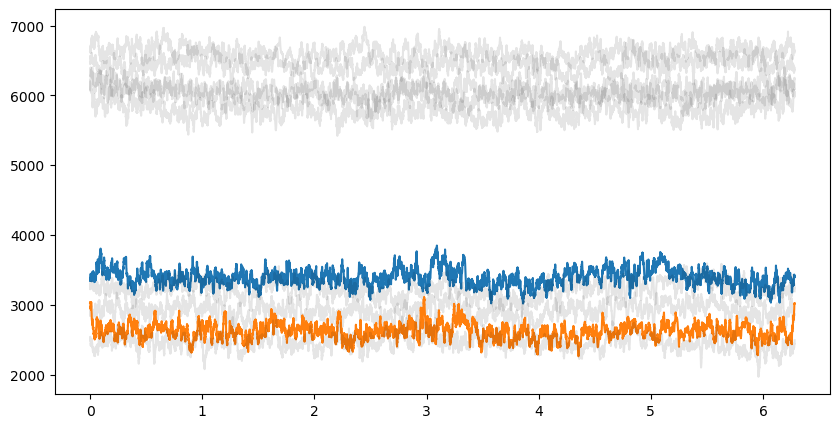

In [5]:
ofset_cmb = 9000 .* vcat(Œ∏_northp, Œ∏_southp) ./ œÄ .- 0.5 |> reverse
figure(figsize=(10,5))
for i = 1:length(Œ∏_northp)
	plot(œÜ_ref, cmb_northp[i] .+ ofset_cmb[i], "k", alpha = 0.1)
end
for i = 1:length(Œ∏_southp)
	if i in [I_slice_1, I_slice_2]
		plot(œÜ_ref, cmb_southp[i] .+ ofset_cmb[i+length(Œ∏_southp)])
	else
		plot(œÜ_ref, cmb_southp[i] .+ ofset_cmb[i+length(Œ∏_southp)], "k", alpha = 0.1)
	end
end
# Note: The cmb is in units mK ‚â° MicroKelvin (1 Kelvin = 1e+6 MicroKelvin)

Digression: Take a peak at the full sky data
--------------------------------------------------------------

The full sky data file is also uploaded to Canvas (file `data/data_full.jld2`) but you don't
need it unless you want to look at it. In which case you will need healpy to 
make the following few plots.
(install healpy at the command line with something like `pip install --user healpy`)

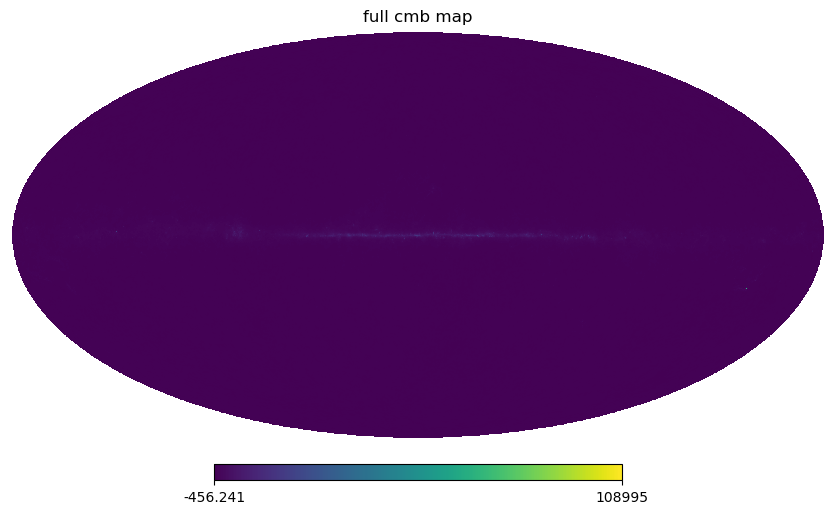

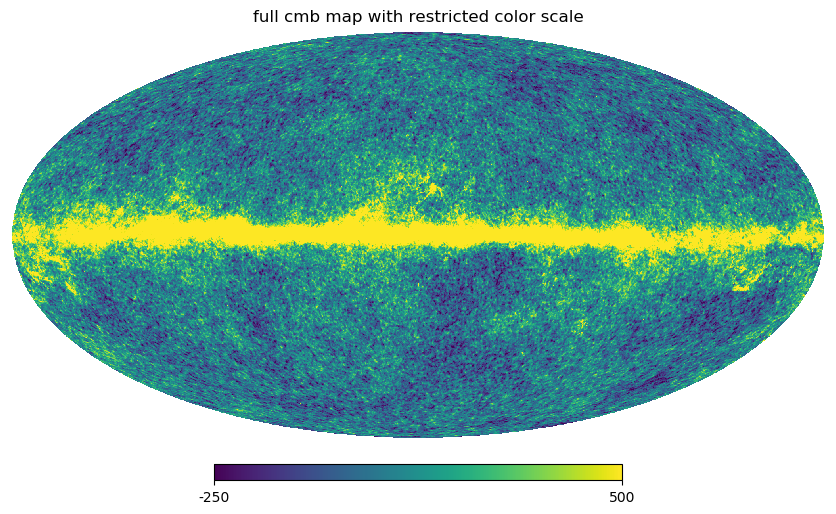

In [6]:
const hp  = pyimport("healpy") 
const ScS = pyimport("scipy.spatial")
const ScI = pyimport("scipy.interpolate")  

cmb_full  = load_it("data_full.jld2", "cmb_full") 
œÜfull     = load_it("data_full.jld2", "œÜfull") 
Œ∏full     = load_it("data_full.jld2", "Œ∏full") 

hp.visufunc.mollview(cmb_full,  xsize=2048, title="full cmb map")

hp.visufunc.mollview(cmb_full, min=-250, max=500, xsize=Nside, title="full cmb map with restricted color scale")

To get a visual where the CMB slices used in the homework come from, they are take at polar 
angles from within these strips.

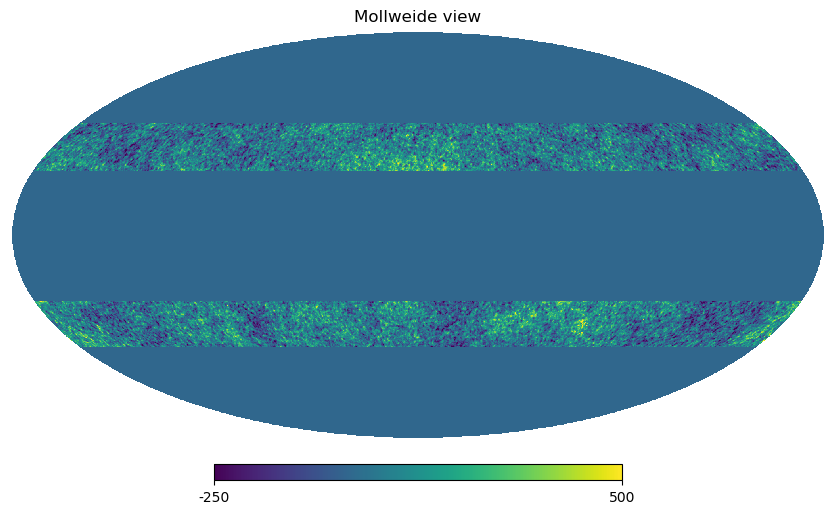

In [7]:
custom_mask   = (Œ∏_northp[1] .<= Œ∏full .<= Œ∏_northp[end]) .| (Œ∏_southp[1] .<= Œ∏full .<= Œ∏_southp[end])
hp.visufunc.mollview(custom_mask .* cmb_full, min=-250, max=500, xsize=Nside)

1-st column of covariance covariance and cross-covariance matrix
-------------------------------------------------------------- 

The isotropic nature of the CMB means we can compute the covariance between the pixel observations 
as a function of the inner product of the three dimensional sphere coordinates. Here is a function that 
"eats polar coordaintes" and returns the tuple of three dim spherical coordinates.

In [8]:
function nÃÇ(Œ∏,œÜ)
	nx =  sin.(Œ∏) .* cos.(œÜ)
	ny =  sin.(Œ∏) .* sin.(œÜ)
	nz =  cos.(Œ∏)
	return (nx, ny, nz)
end

@show nÃÇ(Œ∏1, œÜ_ref[1]);
@show nÃÇ(Œ∏2, œÜ_ref[1]);

nÃÇ(Œ∏1, œÜ_ref[1]) = (0.9130366148294711, 0.0, -0.4078776041666667)
nÃÇ(Œ∏2, œÜ_ref[1]) = (0.7885981873346127, 0.0, -0.6149088541666667)


Now we can compute the inner product between a fixed pixel and all the rest on the
same slice as follows

In [9]:
# we use `Ref` here since `nÃÇ(Œ∏1, œÜ_ref[1])` is a single 3-tuple that we want
# broadcasted to the vector of 3-tuples `nÃÇ.(Œ∏1, œÜ_ref)`

dot.(nÃÇ.(Œ∏1, œÜ_ref), Ref(nÃÇ(Œ∏1, œÜ_ref[1])))

8192-element Array{Float64,1}:
 1.0               
 0.9999997547967509
 0.9999990191871476
 0.9999977931716232
 0.9999960767508986
 0.9999938699259837
 0.9999911726981767
 0.9999879850690642
 0.9999843070405215
 0.9999801386147124
 0.9999754797940889
 0.9999703305813916
 0.9999646909796499
 ‚ãÆ                 
 0.9999646909796499
 0.9999703305813916
 0.9999754797940889
 0.9999801386147124
 0.9999843070405215
 0.9999879850690642
 0.9999911726981767
 0.9999938699259837
 0.9999960767508986
 0.9999977931716232
 0.9999990191871476
 0.9999997547967509

Now we can use the methods given in LocalMethods (which "eats" inner products and returns cov)
to compute the first column of the within group and accross group covariance matrix.

In [10]:
# slice 1 within group covariance to first pixel
Œ£11 = dot.(nÃÇ.(Œ∏1, œÜ_ref), Ref(nÃÇ(Œ∏1, œÜ_ref[1]))) .|> cov_n1_dot_n2
# slice 2 within group covariance to first pixel
Œ£22 = dot.(nÃÇ.(Œ∏2, œÜ_ref), Ref(nÃÇ(Œ∏2, œÜ_ref[1]))) .|> cov_n1_dot_n2
# slice 2 / slice 1 across group covariance to first pixel
Œ£12 = dot.(nÃÇ.(Œ∏1, œÜ_ref), Ref(nÃÇ(Œ∏2, œÜ_ref[1]))) .|> cov_n1_dot_n2
# slice 1 / slice 2 across group covariance to first pixel
Œ£21 = dot.(nÃÇ.(Œ∏2, œÜ_ref), Ref(nÃÇ(Œ∏1, œÜ_ref[1]))) .|> cov_n1_dot_n2

8192-element Array{Float64,1}:
 748.7111817196152
 748.708561033119 
 748.70069908468  
 748.6875962074554
 748.66925295663  
 748.6456701093434
 748.6168486645637
 748.5827898430257
 748.5434950871988
 748.4989660613383
 748.4492046516665
 748.394212966757 
 748.3339933380622
   ‚ãÆ              
 748.3339933380622
 748.394212966757 
 748.4492046516665
 748.4989660613383
 748.5434950871988
 748.5827898430257
 748.6168486645637
 748.6456701093434
 748.66925295663  
 748.6875962074554
 748.70069908468  
 748.708561033119 

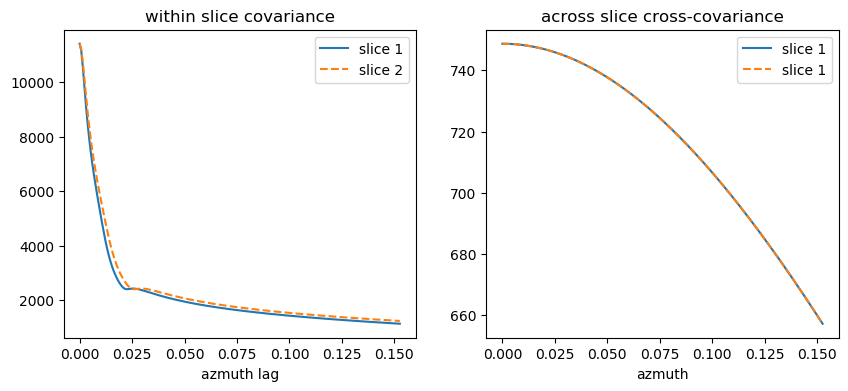

PyObject <matplotlib.legend.Legend object at 0x183dd195f8>

In [11]:
figure(figsize=(10,4))
subplot(1,2,1)
plot(œÜ_ref[1:200], Œ£11[1:200], label="slice 1")
plot(œÜ_ref[1:200], Œ£22[1:200], "--", label="slice 2")
xlabel("azmuth lag")
title("within slice covariance")
legend()
subplot(1,2,2)
plot(œÜ_ref[1:200], Œ£21[1:200], label="slice 1")
plot(œÜ_ref[1:200], Œ£12[1:200], "--", label="slice 1")
xlabel("azmuth")
title("across slice cross-covariance")
legend()

Spectral analysis
--------------------------------------------------------------

Using the fact that these 4 block matrices are circulant, we take the (scaled) Discrete Fourier Transform 
to diagonalize them

In [12]:
# Here are the pixel and grid parameters
period = 2œÄ
ŒîœÜ  = period / N  # pixel spacing
ŒîœÑ  = 2œÄ / period # Fourier spacing
nyq = œÄ / ŒîœÜ
œÑ_ref = ŒîœÑ .* (0:N-1) |> collect 
œÑ_nyq = @. ifelse(œÑ_ref <= nyq, œÑ_ref, œÑ_ref - 2nyq)

8192-element Array{Float64,1}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
  10.0
  11.0
  12.0
   ‚ãÆ  
 -12.0
 -11.0
 -10.0
  -9.0
  -8.0
  -7.0
  -6.0
  -5.0
  -4.0
  -3.0
  -2.0
  -1.0

In [13]:
# Here are the fft operators
ùí≤   = plan_fft(similar(cmb1)) # unscaled fft
ùí∞   = (1/sqrt(N)) * ùí≤         # unitary version
‚Ñ±   = (ŒîœÜ / ‚àö(2œÄ)) * ùí≤        # scaled fft which approximates the integral
sc‚Ñ± = (‚àö(2œÄ)/ŒîœÑ) * ‚Ñ±          # scaling used for the eigenvalues from the first col of the circulantmatrix

0.0007669903939428206 * FFTW forward plan for 8192-element array of Complex{Float64}
(dft-ct-dit/32
  (dftw-direct-32/8 "t3fv_32_avx2_128")
  (dft-vrank>=1-x32/1
    (dft-ct-dit/16
      (dftw-direct-16/8 "t3fv_16_avx2_128")
      (dft-direct-16-x16 "n2fv_16_avx2_128"))))

In [14]:
# These model ‚Ñ±*cmb1 and ‚Ñ±*cmb2
sc‚Ñ±Œ£11 = sc‚Ñ± * Œ£11 .|> real
sc‚Ñ±Œ£22 = sc‚Ñ± * Œ£22 .|> real
sc‚Ñ±Œ£21 = sc‚Ñ± * Œ£21
sc‚Ñ±Œ£12 = sc‚Ñ± * Œ£12

8192-element Array{Complex{Float64},1}:
 154.62796786456275 + 0.0im                   
  599.5697576069812 - 1.6693039523152498e-13im
     779.6420483508 - 4.3671146349382777e-13im
  372.8710732243214 - 3.203992989396178e-13im 
   200.890613085343 - 2.46485680351357e-13im  
  116.5589092472053 - 1.712127287543774e-13im 
  70.99891499401582 - 1.1261678056109393e-13im
  44.79815710632034 - 8.681401263215805e-14im 
  28.98581845967752 - 6.295177814019196e-14im 
 19.120801690535934 - 5.5773372872218086e-14im
 12.844497256954483 - 2.586173561522764e-14im 
  8.730203340362829 - 4.427906767087537e-14im 
  5.974482487946963 - 2.407955523021291e-14im 
                    ‚ãÆ                         
  5.974482487946962 + 1.985838390100208e-14im 
  8.730203340362829 + 4.498660546295634e-14im 
 12.844497256954485 + 3.0380084268093605e-14im
 19.120801690535938 + 5.613048673194449e-14im 
 28.985818459677517 + 6.512424998707842e-14im 
  44.79815710632035 + 8.757701414677976e-14im 
  70.9989149940158

The theory of circulant matrices which 
predicts `(‚àö(2œÄ)/ŒîœÑ) * ‚Ñ±Œ£_ij` is the expected power in 
`‚Ñ±*cmb_i * conj(‚Ñ±*cmbj)`.

In [15]:
‚Ñ±cmb1 = ‚Ñ± * cmb1
‚Ñ±cmb2 = ‚Ñ± * cmb2

8192-element Array{Complex{Float64},1}:
  133.90814399838476 + 0.0im               
   4.598592707638939 - 14.631282498155121im
  11.703730351827819 + 19.90828970987386im 
  -37.33998677029809 - 8.809719862382575im 
  37.647894786328564 - 24.40948634772287im 
 -27.785056911449157 - 13.20704320742245im 
  3.7853845896430225 + 6.436287664700148im 
  7.8393694627857045 - 11.794714499160005im
  13.234914335385945 - 15.317386211599176im
  1.6906889666819933 + 12.459873701402335im
   8.969810355925365 - 7.910895730786761im 
  18.591384350538966 + 11.662364168115035im
  17.818932365135325 - 23.16984493909219im 
                     ‚ãÆ                     
  17.818932365135325 + 23.169844939092187im
  18.591384350538966 - 11.662364168115035im
   8.969810355925361 + 7.910895730786761im 
  1.6906889666819935 - 12.45987370140233im 
  13.234914335385948 + 15.317386211599178im
   7.839369462785704 + 11.794714499160007im
  3.7853845896430243 - 6.436287664700148im 
 -27.785056911449157 + 13.20704320

We can look at the "power" in these maps, i.e. |‚Ñ±cmb1[k]|^2 and |‚Ñ±cmb2[k]|^2, compared to 
what the signal covariance predicts

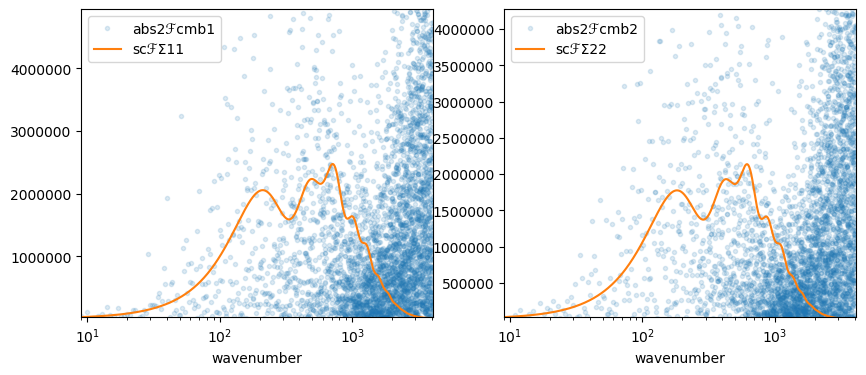

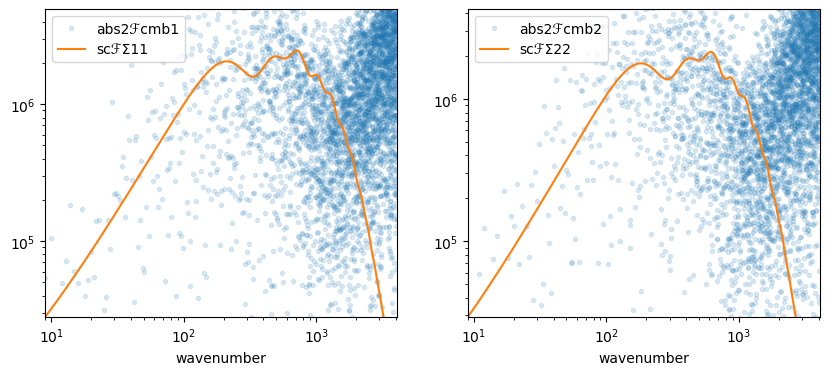

In [16]:
let plt_range = 10:N√∑2+1, 
	k = œÑ_ref[plt_range],
	km = k.^2,
	abs2‚Ñ±cmb1 = abs2.(‚Ñ±cmb1),
	abs2‚Ñ±cmb2 = abs2.(‚Ñ±cmb2),
	sc‚Ñ±Œ£11 = sc‚Ñ±Œ£11,
	sc‚Ñ±Œ£22 = sc‚Ñ±Œ£22


	for myplot ‚àà [semilogx, loglog]

		figure(figsize=(10,4))
		sub = subplot(1,2,1)
			myplot(k, km .* abs2‚Ñ±cmb1[plt_range], label="abs2‚Ñ±cmb1", color=colors[1], ".", alpha=0.15)
			myplot(k, km .* sc‚Ñ±Œ£11[plt_range], label="sc‚Ñ±Œ£11", color=colors[2])
			xlabel("wavenumber")
			sub.set_ylim((km .* sc‚Ñ±Œ£11[plt_range])[1], 2*maximum(km .* sc‚Ñ±Œ£11[plt_range])) 
			sub.set_xlim(k[1], maximum(k)) 
			legend()
		sub = subplot(1,2,2)
			myplot(k, km .* abs2‚Ñ±cmb2[plt_range], label="abs2‚Ñ±cmb2", color=colors[1], ".", alpha=0.15)
			myplot(k, km .* sc‚Ñ±Œ£22[plt_range], label="sc‚Ñ±Œ£22", color=colors[2])
			xlabel("wavenumber")
			sub.set_ylim((km .* sc‚Ñ±Œ£22[plt_range])[1], 2*maximum(km .* sc‚Ñ±Œ£22[plt_range])) 
			sub.set_xlim(k[1], maximum(k)) 
			legend()

	end # for loop over myplot

end

Spectral impact of the noise and beam
--------------------------------------------------------------

From `https://wiki.cosmos.esa.int/planckpla2015/index.php/Summary_of_HFI_data_characteristics`


|                                           |       |  
|:------------------------------------------|------:|
| Effective beam solid angle Œ© [arcmin¬≤]    | 60.44 |
| Effecitive beam FWHM‚ÇÅ [arcmin]            | 7.3   |
| Sensitivity per beam solid angle [ŒºK_CMB] | 4.3   | 
| Temp sensitivity [ŒºKdeg]                  | 0.55  |

In [17]:
# Compute the standard deviation of white noise in each Healpix pixel. 
# Note: the Healpix pixel area ‚âà 1.7¬≤ [arcmin¬≤] with Nside = 2048.

# #############
#
#
# For the homework ... assign the variable `sd_of_noise_per_1p7_arcmin_pixel` the correct value.
# Note: the Healpix pixel area ‚âà 1.7¬≤ [arcmin¬≤] with Nside = 2048.
#
#
# ##############

sd_of_noise_per_1p7_arcmin_pixel = 60.44/1.7^2
bFWHM_arcmin = 7.3 # arcmin

7.3

In [19]:
‚Ñ±ùó°‚Ñ±·¥¥, ‚Ñ±ùóï = let œÉn = sd_of_noise_per_1p7_arcmin_pixel, bfwhm = bFWHM_arcmin
 	ùó° = fill(œÉn^2, size(œÑ_ref))
 	‚Ñ±ùó°‚Ñ±·¥¥ = (ŒîœÜ / ŒîœÑ) .* ùó° ### note the scaling
 	bFWHM_rad = deg2rad(bfwhm/60)
 	‚Ñ±ùóï = @. exp( - (bFWHM_rad^2) * abs2(œÑ_nyq) / (16*log(2)) )
 	‚Ñ±ùó°‚Ñ±·¥¥, ‚Ñ±ùóï 
end

([0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864  ‚Ä¶  0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864, 0.3354618599315864], [1.0, 0.9999995934139979, 0.9999983736569836, 0.9999963407319328, 0.9999934946438046, 0.9999898353995421, 0.9999853630080723, 0.9999800774803053, 0.9999739788291351, 0.9999670670694394  ‚Ä¶  0.999959342218079, 0.9999670670694394, 0.9999739788291351, 0.9999800774803053, 0.9999853630080723, 0.9999898353995421, 0.9999934946438046, 0.9999963407319328, 0.9999983736569836, 0.9999995934139979])

Now we can plot the theory beamed signal, the noise and binned bandpowers

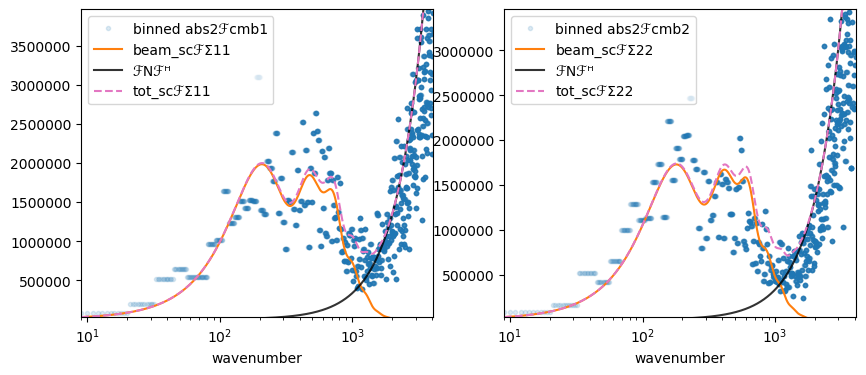

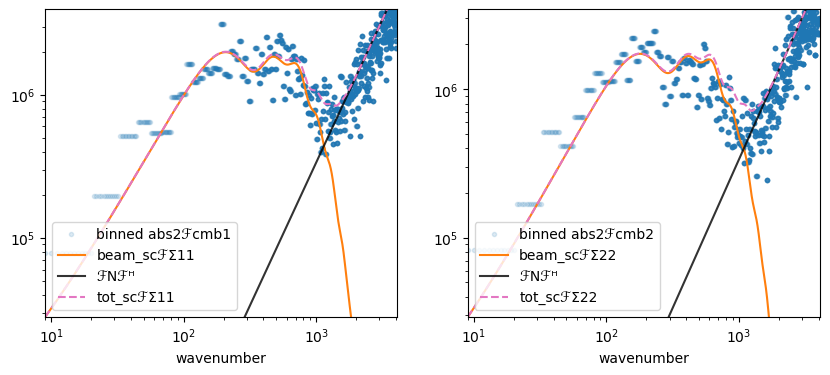

In [20]:
let bin_powers_width = 12,
	plt_range = 10:N√∑2+1, 
	k = œÑ_ref[plt_range],
	km = k.^2, 
	abs2‚Ñ±cmb1 = abs2.(‚Ñ±cmb1),
	abs2‚Ñ±cmb2 = abs2.(‚Ñ±cmb2),
	sc‚Ñ±Œ£11 = sc‚Ñ±Œ£11,
	sc‚Ñ±Œ£22 = sc‚Ñ±Œ£22


	beam_sc‚Ñ±Œ£11 = sc‚Ñ±Œ£11 .* abs2.(‚Ñ±ùóï)
	beam_sc‚Ñ±Œ£22 = sc‚Ñ±Œ£22 .* abs2.(‚Ñ±ùóï)
	
	tot_sc‚Ñ±Œ£11 = sc‚Ñ±Œ£11 .* abs2.(‚Ñ±ùóï) .+ ‚Ñ±ùó°‚Ñ±·¥¥
	tot_sc‚Ñ±Œ£22 = sc‚Ñ±Œ£22 .* abs2.(‚Ñ±ùóï) .+ ‚Ñ±ùó°‚Ñ±·¥¥

	for myplot ‚àà [semilogx, loglog]

		figure(figsize=(10,4))
		sub = subplot(1,2,1)
			myplot(k, 
				km .* abs2‚Ñ±cmb1[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
				label="binned abs2‚Ñ±cmb1", color=colors[1], ".", alpha=0.15
			)
			myplot(k, km .* beam_sc‚Ñ±Œ£11[plt_range], label="beam_sc‚Ñ±Œ£11", color=colors[2])
			myplot(k, km .* ‚Ñ±ùó°‚Ñ±·¥¥[plt_range], label="‚Ñ±N‚Ñ±·¥¥", "k", alpha = 0.8)
			myplot(k, km .* tot_sc‚Ñ±Œ£11[plt_range], "--", label="tot_sc‚Ñ±Œ£11", color=colors[7])
			xlabel("wavenumber")
			sub.set_ylim((km .* beam_sc‚Ñ±Œ£11[plt_range])[1], 2*maximum(km .* beam_sc‚Ñ±Œ£11[plt_range])) 
			sub.set_xlim(k[1], maximum(k)) 
			legend()
		sub = subplot(1,2,2)
			myplot(k, 
				km .* abs2‚Ñ±cmb2[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
				label="binned abs2‚Ñ±cmb2", color=colors[1], ".", alpha=0.15
			)
			myplot(k, km .* beam_sc‚Ñ±Œ£22[plt_range], label="beam_sc‚Ñ±Œ£22", color=colors[2])
			myplot(k, km .* ‚Ñ±ùó°‚Ñ±·¥¥[plt_range], label="‚Ñ±N‚Ñ±·¥¥", "k", alpha = 0.8)
			myplot(k, km .* tot_sc‚Ñ±Œ£22[plt_range], "--", label="tot_sc‚Ñ±Œ£22", color=colors[7])
			xlabel("wavenumber")
			sub.set_ylim((km .* beam_sc‚Ñ±Œ£22[plt_range])[1], 2*maximum(km .* beam_sc‚Ñ±Œ£22[plt_range])) 
			sub.set_xlim(k[1], maximum(k)) 
			legend()

	end # for loop over myplot
		
end

Also the cross correlation. The circulant matrix theory predicts that 
`E(‚Ñ±cmb1 .* conj(‚Ñ±cmb2)) =  sc‚Ñ±Œ£12 .* abs2.(‚Ñ±ùóï)` and `E(‚Ñ±cmb2 .* conj(‚Ñ±cmb1)) =  sc‚Ñ±Œ£21 .* abs2.(‚Ñ±ùóï)`

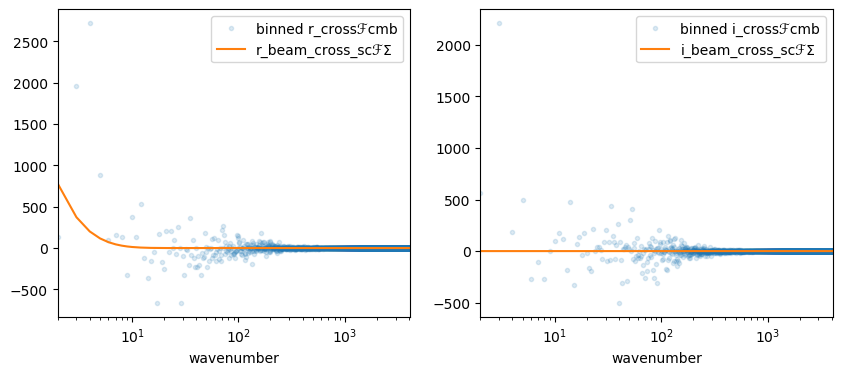

PyObject <matplotlib.legend.Legend object at 0x184e18a490>

In [20]:
let bin_powers_width = 0,
	plt_range = 2:N√∑2+1, 
	k = œÑ_ref[plt_range],
	km = k.^0, 
	cross‚Ñ±cmb12 = ‚Ñ±cmb1 .* conj(‚Ñ±cmb2),
	cross‚Ñ±cmb21 = ‚Ñ±cmb2 .* conj(‚Ñ±cmb1),
	sc‚Ñ±Œ£12 = sc‚Ñ±Œ£12,
	sc‚Ñ±Œ£21 = sc‚Ñ±Œ£21


	r_cross‚Ñ±cmb =  (cross‚Ñ±cmb12 .+ cross‚Ñ±cmb21) ./ 2 .|> real # this must be real 
	i_cross‚Ñ±cmb =  (cross‚Ñ±cmb12 .- cross‚Ñ±cmb21) ./ 2 .|> imag # this must be purely imaginary
	
	r_beam_cross_sc‚Ñ±Œ£ = real.((sc‚Ñ±Œ£12 .+ sc‚Ñ±Œ£21) ./ 2) .* abs2.(‚Ñ±ùóï)
	i_beam_cross_sc‚Ñ±Œ£ = imag.((sc‚Ñ±Œ£12 .- sc‚Ñ±Œ£21) ./ 2) .* abs2.(‚Ñ±ùóï)

	myplot = semilogx #plot
	figure(figsize=(10,4))
	sub = subplot(1,2,1)
		myplot(k, 
			km .* r_cross‚Ñ±cmb[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
			label="binned r_cross‚Ñ±cmb", color=colors[1], ".", alpha=0.15
		)
		myplot(k, km .* r_beam_cross_sc‚Ñ±Œ£[plt_range], label="r_beam_cross_sc‚Ñ±Œ£", color=colors[2])
		xlabel("wavenumber")
		#sub.set_ylim((km .* r_beam_cross_sc‚Ñ±Œ£[plt_range])[1], 2*maximum(km .* r_beam_cross_sc‚Ñ±Œ£[plt_range])) 
		sub.set_xlim(k[2], maximum(k)) 
		legend()
	sub = subplot(1,2,2)
		myplot(k, 
			km .* i_cross‚Ñ±cmb[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
			label="binned i_cross‚Ñ±cmb", color=colors[1], ".", alpha=0.15
		)
		myplot(k, km .* i_beam_cross_sc‚Ñ±Œ£[plt_range], label="i_beam_cross_sc‚Ñ±Œ£", color=colors[2])
		xlabel("wavenumber")
		#sub.set_ylim((km .* i_beam_cross_sc‚Ñ±Œ£[plt_range])[1], 2*maximum(km .* i_beam_cross_sc‚Ñ±Œ£[plt_range])) 
		sub.set_xlim(k[2], maximum(k)) 
		legend()

		
end

Frequency-by-frequency de-correlation of ‚Ñ±cmb1 and ‚Ñ±cmb2
--------------------------------------------------------------

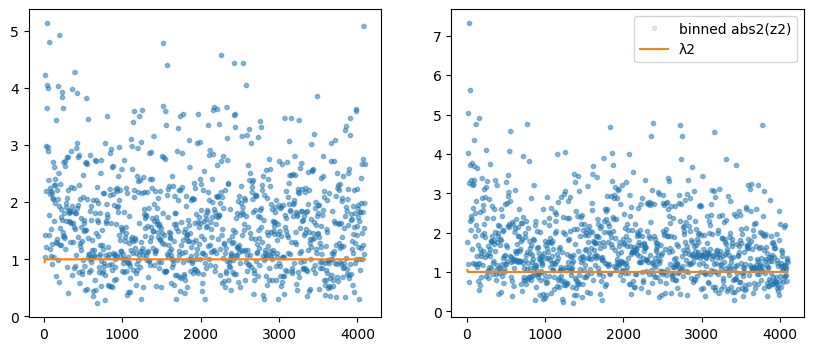

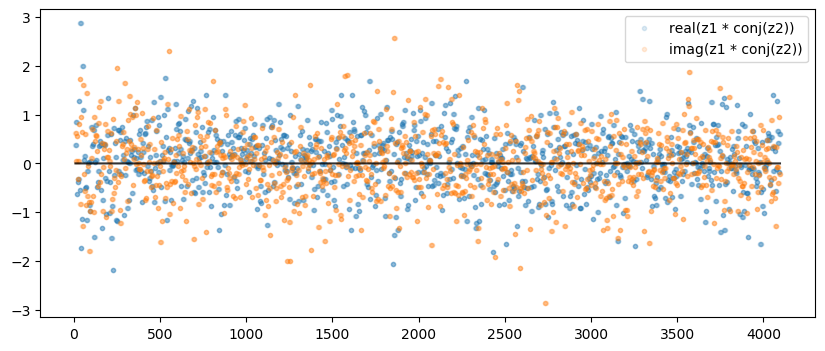

PyObject <matplotlib.legend.Legend object at 0x183e950fd0>

In [21]:
tot_sc‚Ñ±Œ£11 = sc‚Ñ±Œ£11 .* abs2.(‚Ñ±ùóï) .+ ‚Ñ±ùó°‚Ñ±·¥¥
tot_sc‚Ñ±Œ£22 = sc‚Ñ±Œ£22 .* abs2.(‚Ñ±ùóï) .+ ‚Ñ±ùó°‚Ñ±·¥¥
tot_sc‚Ñ±Œ£21 = sc‚Ñ±Œ£21 .* abs2.(‚Ñ±ùóï) .|> real

Œª = tot_sc‚Ñ±Œ£21 ./ sqrt.( tot_sc‚Ñ±Œ£11 .* tot_sc‚Ñ±Œ£22)
nrm_‚Ñ±cmb1 = ‚Ñ±cmb1 ./ sqrt.(tot_sc‚Ñ±Œ£11)
nrm_‚Ñ±cmb2 = ‚Ñ±cmb2 ./ sqrt.(tot_sc‚Ñ±Œ£22)

z1 = nrm_‚Ñ±cmb1 .+ exp.(im.*angle.(Œª)) .* nrm_‚Ñ±cmb2
z2 = nrm_‚Ñ±cmb1 .- exp.(im.*angle.(Œª)) .* nrm_‚Ñ±cmb2
Œª1 = 1 .- abs.(Œª)
Œª2 = 1 .+ abs.(Œª)

let bin_powers_width = 4,
	plt_range = 10:N√∑2+1, 
	k = œÑ_ref[plt_range],
	abs2_z1 = abs2.(z1),
	abs2_z2 = abs2.(z2),
	cross_z2_z1 = z2 .* conj.(z1),
	Œª1 = Œª1,
	Œª2 = Œª2

	figure(figsize=(10,4))
		sub = subplot(1,2,1)
		plot(
			k, 
			abs2_z1[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
			label="binned abs2(z1)", color=colors[1], ".", alpha=0.15
		)
		plot(k, Œª1[plt_range], label="Œª1", color=colors[2])

		sub = subplot(1,2,2)
		plot(
			k, 
			abs2_z2[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
			label="binned abs2(z2)", color=colors[1], ".", alpha=0.15
		)
		plot(k, Œª2[plt_range], label="Œª2", color=colors[2])
		legend()


	figure(figsize=(10,4))
		plot(
			k, 
			real.(cross_z2_z1)[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
			label="real(z1 * conj(z2))", color=colors[1], ".", alpha=0.15
		)
		plot(
			k, 
			imag.(cross_z2_z1)[plt_range] |> x->LocalMethods.bin_mean(x; bin = bin_powers_width), 
			label="imag(z1 * conj(z2))", color=colors[2], ".", alpha=0.15
		)
		plot(k, fill(0, size(k)), "k", alpha = 0.8)
		legend()


end

Wiener filtered south pole cap
--------------------------------------------------------------

First we multiply the data (i.e. the two circular slices stacked) by the inverse cov matrix of the data.

Now we make a function that computes the wiener filter on any unobserved circular slice.

In [22]:
# #############
#
#
# For the homework ... 
# Create a function `wf_cmb_fun(Œ∏)` that takes in a polar angle `Œ∏` and
# returns the conditional expected value of `cmb` at the azmuth grid values `œÜ_ref`.
#
#
# ##############
let ‚Ñ±ùóï=‚Ñ±ùóï,
    sc‚Ñ±Œ£11=sc‚Ñ±Œ£11,
    sc‚Ñ±Œ£12=sc‚Ñ±Œ£12,
    sc‚Ñ±Œ£21=sc‚Ñ±Œ£21,
    sc‚Ñ±Œ£22=sc‚Ñ±Œ£22,
    ‚Ñ±cmb1=‚Ñ±cmb1,
    ‚Ñ±cmb2=‚Ñ±cmb2,
    Œ∏1=Œ∏1,
    Œ∏2=Œ∏2,
    ‚Ñ±ùó°‚Ñ±·¥¥=‚Ñ±ùó°‚Ñ±·¥¥


    global function wf_cmb_fun(Œ∏3)
        Œ£31 = dot.(nÃÇ.(Œ∏3, œÜ_ref), Ref(nÃÇ(Œ∏1, œÜ_ref[1]))) .|> cov_n1_dot_n2
        Œ£32 = dot.(nÃÇ.(Œ∏3, œÜ_ref), Ref(nÃÇ(Œ∏2, œÜ_ref[1]))) .|> cov_n1_dot_n2
        sc‚Ñ±Œ£31 = sc‚Ñ± * Œ£31
        sc‚Ñ±Œ£32 = sc‚Ñ± * Œ£32

        A11=(abs2.(‚Ñ±ùóï).*sc‚Ñ±Œ£11+‚Ñ±ùó°‚Ñ±·¥¥)
        A12=(abs2.(‚Ñ±ùóï).*(sc‚Ñ±Œ£12+sc‚Ñ±Œ£21)./2)
        A22=(abs2.(‚Ñ±ùóï).*sc‚Ñ±Œ£22+‚Ñ±ùó°‚Ñ±·¥¥)
        B11=A11.^(-1)+A11.^(-1).*A12.*(A22.-A12.*A11.^(-1).*A12).^(-1).*A12.*A11.^(-1)
        B12=-A11.^(-1).*A12.*(A22.-A12.*A11.^(-1).*A12).^(-1)
        B21=-(A22.-A12.*A11.^(-1).*A12).^(-1).*A12.*A11.^(-1)
        B22=(A22.-A12.*A11.^(-1).*A12).^(-1)
        C1=abs.(‚Ñ±ùóï).*sc‚Ñ±Œ£31
        C2=abs.(‚Ñ±ùóï).*sc‚Ñ±Œ£32

        ‚Ñ±cmb3_pre=(C1.*B11.+C2.*B21).*‚Ñ±cmb1+(C1.*B12.+C2.*B22).*‚Ñ±cmb2
        cmb2_pre=‚Ñ± \‚Ñ±cmb3_pre .|> real
        return cmb2_pre
    end
end

wf_cmb_fun (generic function with 1 method)

Finally we create a grid of polar angles to predict on

In [23]:
# if at north pole
#Œ∏s = range(0.001, max(Œ∏2, Œ∏1) .+ 0.1,   length=250) |> transpose

# if at south pole
Œ∏s = range(min(Œ∏2, Œ∏1) .- 0.1, œÄ,  length=150) |> transpose

Œ∏grid =      Œ∏s .+ 0 .* œÜ_ref
œÜgrid = 0 .* Œ∏s .+      œÜ_ref


function make_wf_cmb_mat(Œ∏s, œÜ_ref)
	wf_cmb_mat_local = 0 .* Œ∏s .+ 0 .* œÜ_ref
	@showprogress for icol = 1:length(Œ∏s)
		#print("$icol,")
		wf_cmb_mat_local[:,icol] = wf_cmb_fun(Œ∏s[icol])
	end
	wf_cmb_mat_local
end

wf_cmb_mat = make_wf_cmb_mat(Œ∏s, œÜ_ref)

Progress: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:08:06


8192√ó150 Array{Float64,2}:
 41.605   43.771   45.9281  48.047   50.0817  ‚Ä¶  -108.511  -108.582  -108.622
 41.9015  44.0855  46.2619  48.4018  50.4586     -108.511  -108.582  -108.622
 42.1981  44.4002  46.5961  48.7574  50.8366     -108.511  -108.582  -108.622
 42.4947  44.7152  46.9307  49.1137  51.2159     -108.51   -108.582  -108.622
 42.7915  45.0303  47.2658  49.4708  51.5964     -108.51   -108.582  -108.622
 43.0883  45.3455  47.6014  49.8286  51.9781  ‚Ä¶  -108.51   -108.582  -108.622
 43.3852  45.661   47.9374  50.1871  52.361      -108.51   -108.581  -108.622
 43.6821  45.9766  48.2739  50.5463  52.7451     -108.51   -108.581  -108.622
 43.9791  46.2925  48.6109  50.9062  53.1305     -108.51   -108.581  -108.622
 44.276   46.6085  48.9483  51.2668  53.517      -108.509  -108.581  -108.622
 44.5729  46.9247  49.2862  51.6281  53.9048  ‚Ä¶  -108.509  -108.581  -108.622
 44.8697  47.2411  49.6244  51.9901  54.2936     -108.509  -108.581  -108.622
 45.1665  47.5577  49.963   52

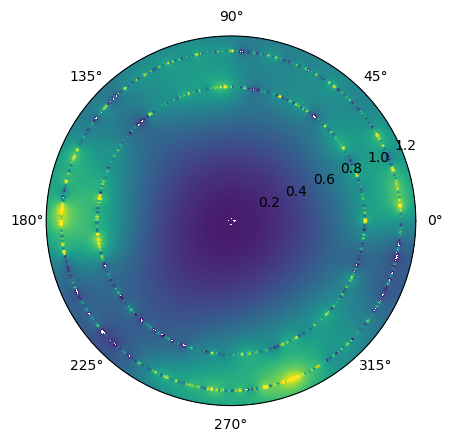

PyObject <matplotlib.collections.QuadMesh object at 0x183e90d208>

In [25]:
fig = figure()
ax  = mplot3d.Axes3D(fig)
subplot(projection="polar")

# if at north pole
# pcolormesh(œÜgrid, Œ∏grid, wf_cmb_mat, vmin=-125, vmax=225)

# if at south pole
pcolormesh(œÜgrid, œÄ .- Œ∏grid, wf_cmb_mat, vmin=-135, vmax=235)
# grid()